In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import shutil
from functools import partial

import numpy as np
import torch
from box import ConfigBox
from dvclive import Live
from dvclive.fastai import DVCLiveCallback
from fastai.data.all import Normalize, get_files
from fastai.metrics import DiceMulti
from fastai.vision.all import (Resize, SegmentationDataLoaders, aug_transforms,
                               imagenet_stats, models, unet_learner)
from ruamel.yaml import YAML

### Load data and split it into train/test

In [4]:
test_pct = 0.25

img_fpaths = get_files(Path("data") / "pool_data" / "images", extensions=".jpg")

train_data_dir = Path("data") / "train_data"
train_data_dir.mkdir(exist_ok=True)
test_data_dir = Path("data") / "test_data"
test_data_dir.mkdir(exist_ok=True)
for img_path in img_fpaths:
    msk_path = Path("data") / "pool_data" / "masks" / f"{img_path.stem}.png"
    if np.random.uniform() <= test_pct:
        shutil.copy(img_path, test_data_dir)
        shutil.copy(msk_path, test_data_dir)
    else:
        shutil.copy(img_path, train_data_dir)
        shutil.copy(msk_path, train_data_dir)

### Create a data loader

In [5]:
def get_mask_path(x, train_data_dir):
    return Path(train_data_dir) / f"{Path(x).stem}.png"

In [6]:
bs = 8
valid_pct = 0.20
img_size = 512

data_loader = SegmentationDataLoaders.from_label_func(
        path=train_data_dir,
        fnames=get_files(train_data_dir, extensions=".jpg"),
        label_func=partial(get_mask_path, train_data_dir=train_data_dir),
        codes=["not-pool", "pool"],
        bs=bs,
        valid_pct=valid_pct,
        item_tfms=Resize(img_size),
        batch_tfms=[
            *aug_transforms(size=img_size),
            Normalize.from_stats(*imagenet_stats),
        ],
    )

### Review a sample batch of data

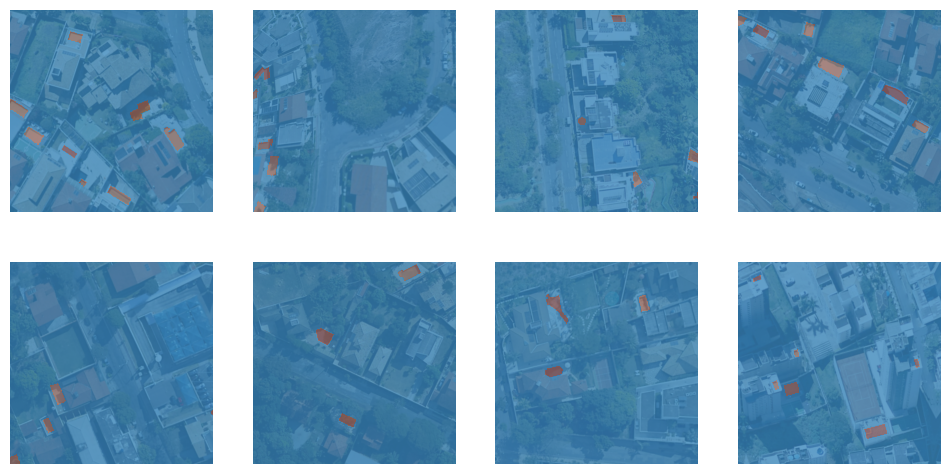

In [7]:
data_loader.show_batch(alpha=0.7)

### Train multiple models with different learning rates using `DVCLiveCallback`

In [8]:
train_arch = 'resnet18'

for base_lr in [0.001, 0.005, 0.01]:
    live = Live(dir=os.path.join('results', 'train'), 
            report="md", 
            save_dvc_exp=True)
    live.summary["base_lr"] =base_lr
    live.make_summary()
    learn = unet_learner(data_loader, 
                        arch=getattr(models, train_arch), 
                        metrics=DiceMulti)
    fine_tune_args = {
        'epochs': 8,
        'base_lr': base_lr
        }
    learn.fine_tune(
        **fine_tune_args,
        cbs=[DVCLiveCallback(live=live)])

epoch,train_loss,valid_loss,dice_multi,time
0,0.658835,0.134496,0.495742,00:07


epoch,train_loss,valid_loss,dice_multi,time
0,0.101240,0.116584,0.495742,00:06
1,0.077819,0.052910,0.845828,00:06
2,0.057657,0.014751,0.924096,00:06
3,0.045121,0.014646,0.931302,00:06
4,0.037028,0.014207,0.922231,00:06
5,0.032029,0.011054,0.937107,00:06
6,0.028232,0.013187,0.923484,00:06
7,0.025286,0.013857,0.920296,00:06


epoch,train_loss,valid_loss,dice_multi,time
0,0.340594,0.083677,0.495742,00:06


epoch,train_loss,valid_loss,dice_multi,time
0,0.052448,0.026666,0.909269,00:06
1,0.039602,0.023173,0.889840,00:06
2,0.033602,0.020826,0.888474,00:06
3,0.028726,0.014433,0.925744,00:06
4,0.025092,0.015925,0.917243,00:06
5,0.022235,0.014135,0.931371,00:06
6,0.019938,0.019934,0.911383,00:06
7,0.018329,0.016472,0.923019,00:06


epoch,train_loss,valid_loss,dice_multi,time
0,1.101874,0.088053,0.495742,00:06


epoch,train_loss,valid_loss,dice_multi,time
0,0.067210,0.029897,0.861188,00:06
1,0.044947,0.030106,0.811485,00:06
2,0.041026,0.019384,0.915279,00:06
3,0.035492,0.020302,0.890720,00:06
4,0.031328,0.013216,0.924537,00:06
5,0.028010,0.013930,0.922230,00:06
6,0.025315,0.011945,0.936597,00:06
7,0.023068,0.012316,0.933407,00:06


In [15]:
# Compare experiments
!dvc exp show --only-changed

 ───────────────────────────────────────────────────────────────────────────────────────── 
  Experiment                 Created        base_lr   train.loss   eval.loss   dice_multi  
 ───────────────────────────────────────────────────────────────────────────────────────── 
  workspace                  -                 0.01     0.023068    0.012316      0.93341  
  dev                        Jan 18, 2023         -     0.020976    0.017044      0.90846  
  ├── 911cb9d [hexed-jass]   02:24 PM          0.01     0.023068    0.012316      0.93341  
  ├── 2f81695 [funny-iglu]   02:23 PM         0.005     0.018329    0.016472      0.92302  
  └── b466093 [rathe-cree]   02:22 PM         0.001     0.025286    0.013857       0.9203  
 ───────────────────────────────────────────────────────────────────────────────────────── 


In [16]:
# Apply best performing experiment to the workspace
!dvc exp apply hexed-jass

  0% Checkout|                                     |0/183 [00:00<?,     ?file/s]
!
Building data objects from data/pool_data             |0.00 [00:00,      ?obj/s]
Changes for experiment 'hexed-jass' have been applied to your current workspace.


### Review sample preditions vs ground truth

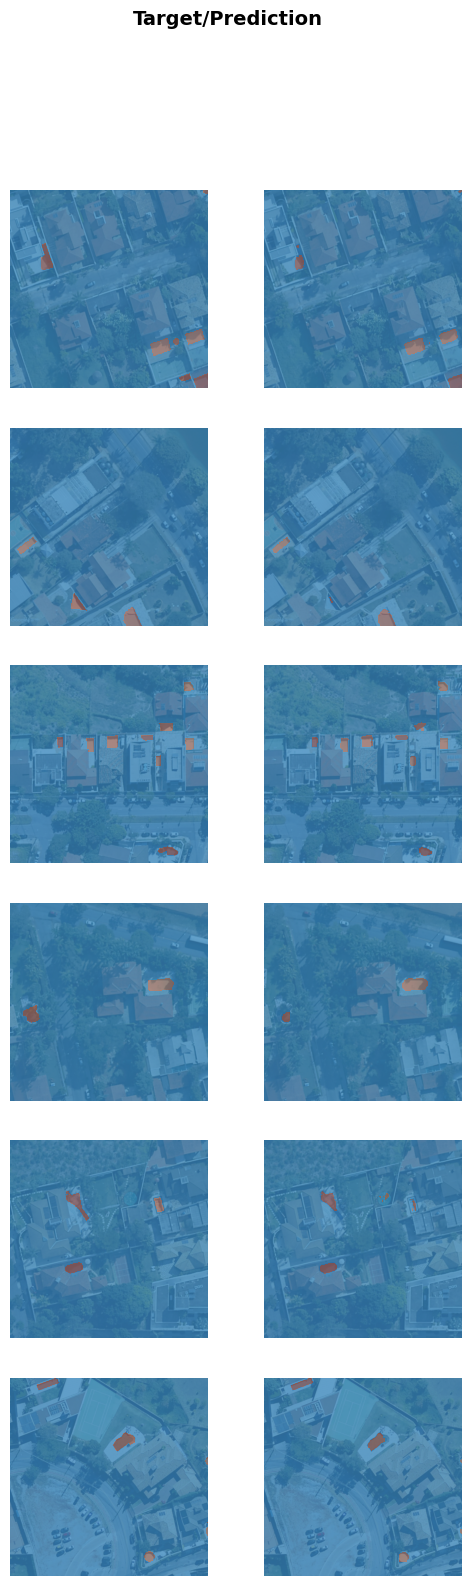

In [17]:
learn.show_results(max_n=6, alpha=0.7)

### Review instances where loss function values are the highest (i.e. model is likely to be wrong)

In [18]:
from fastai.vision.all import SegmentationInterpretation

interp = SegmentationInterpretation.from_learner(learn)

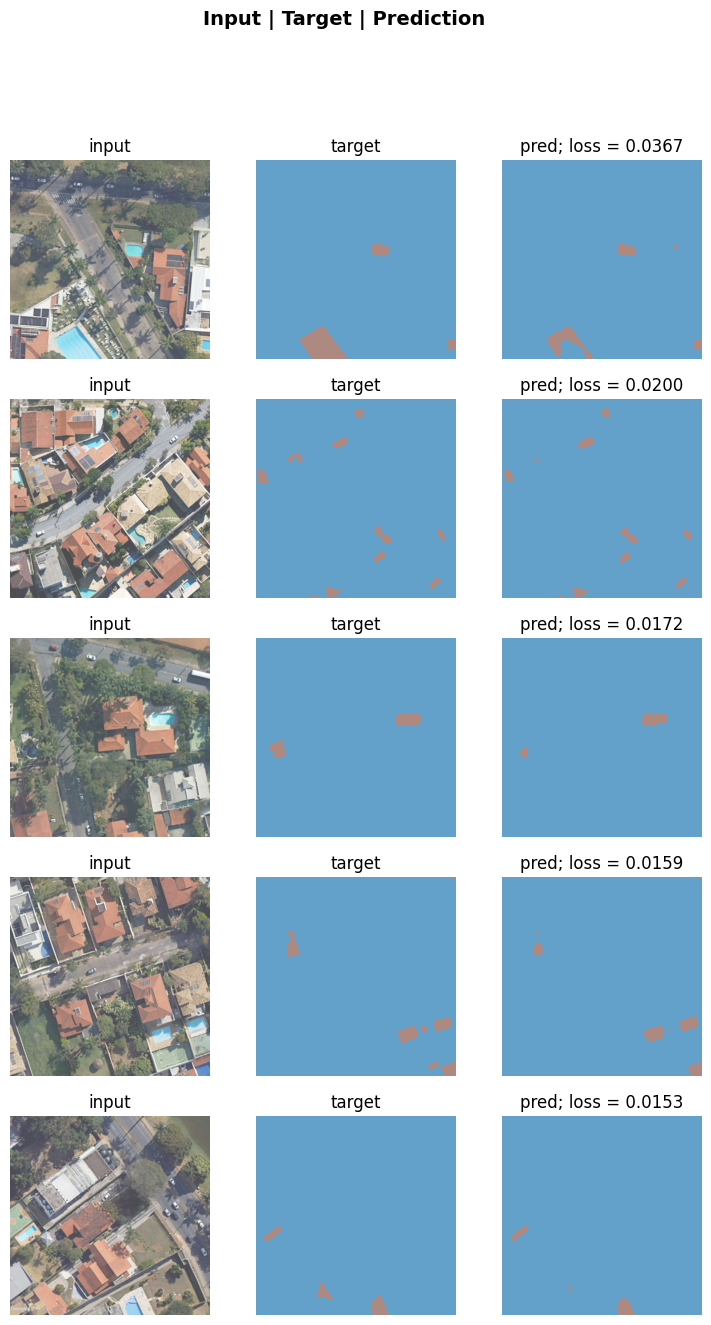

In [19]:
interp.plot_top_losses(k=5, alpha=0.7)